In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np

# DGL
import dgl
import dgl.function as fn
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler

# 
import os
import glob, tqdm

import matplotlib.pyplot as plt

/m/home/home2/25/gyntera1/unix/mambaforge/envs/torch/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
def index_binding_dataset(path):
    df = pd.read_csv(path, comment='#', delimiter=r"\s+", usecols=[0,1,2,3,4], index_col=None, header=None)
    df.columns = ["PDB code", "resolution", "release year", "-logKd/Ki", "Kd/Ki"]
    
    # names = map(lambda s: s.split('_')[0], list(map(os.path.basename, glob.glob(f"{dataset_dir}/*_ligand.bin"))))

    # df = df[df["PDB code"].isin(names)]
    df = df[df["Kd/Ki"].str.contains("=")].reset_index(drop=True)

    df["unit"] = ""
    df["value"] = 0.0
    
    df.loc[df["Kd/Ki"].str.contains("Kd"), "unit"] = "Kd"
    df.loc[df["Kd/Ki"].str.contains("Ki"), "unit"] = "Ki"
    df.loc[df["Kd/Ki"].str.contains("IC50"), "unit"] = "IC50"
    
    # df.loc[df["Kd/Ki"].str.contains("M"), "value"] = df.loc[df["Kd/Ki"].str.contains("M"), "Kd/Ki"].str.split('=').str[1].str.split("M").str[0].astype(float)
    df.loc[df["Kd/Ki"].str.contains("mM"), "value"] = df.loc[df["Kd/Ki"].str.contains("mM"), "Kd/Ki"].str.split('=').str[1].str.split("mM").str[0].astype(float) * 10**-3
    df.loc[df["Kd/Ki"].str.contains("uM"), "value"] = df.loc[df["Kd/Ki"].str.contains("uM"), "Kd/Ki"].str.split('=').str[1].str.split("uM").str[0].astype(float) * 10**-6
    df.loc[df["Kd/Ki"].str.contains("nM"), "value"] = df.loc[df["Kd/Ki"].str.contains("nM"), "Kd/Ki"].str.split('=').str[1].str.split("nM").str[0].astype(float) * 10**-9
    df.loc[df["Kd/Ki"].str.contains("pM"), "value"] = df.loc[df["Kd/Ki"].str.contains("pM"), "Kd/Ki"].str.split('=').str[1].str.split("pM").str[0].astype(float) * 10**-12
    df.loc[df["Kd/Ki"].str.contains("fM"), "value"] = df.loc[df["Kd/Ki"].str.contains("fM"), "Kd/Ki"].str.split('=').str[1].str.split("fM").str[0].astype(float) * 10**-15
    return df.sample(frac=1).reset_index(drop=True)


In [4]:
df = index_binding_dataset("data/PDBbind_refined/index/INDEX_general_PL_data.2020")
# df = df[df["unit"] == "IC50"]
# df = df.loc[:5000]
df

,PDB code,resolution,release year,-logKd/Ki,Kd/Ki,unit,value
0,5cu2,1.71,2016,4.24,Kd=58uM,Kd,5.800000e-05
1,5nih,1.30,2017,6.87,Ki=134nM,Ki,1.340000e-07
2,6o5a,1.67,2019,6.29,Ki=514nM,Ki,5.140000e-07
3,4w9q,1.08,2014,6.85,IC50=140nM,IC50,1.400000e-07
4,2y6d,1.60,2011,7.10,IC50=79nM,IC50,7.900000e-08
...,...,...,...,...,...,...,...
18942,2gek,2.40,2007,7.52,Kd=0.03uM,Kd,3.000000e-08
18943,4phu,2.33,2014,7.92,Kd=12.04nM,Kd,1.204000e-08
18944,4l7g,1.38,2013,4.00,IC50=99.3uM,IC50,9.930000e-05
18945,6dge,1.91,2018,6.72,Ki=0.19uM,Ki,1.900000e-07


In [5]:
def get_dataloader(df):
    dataset = []
    for index, row in tqdm.tqdm(df.iterrows()):
        name = row['PDB code']
        # lig_path = f"data/dataset/{name}_ligand.bin"
        # rec_path = f"data/dataset/{name}_protein.bin"
        path = f"data/dataset/{name}_complex.bin"
        # if os.path.exists(lig_path) and os.path.exists(rec_path):
        #     lig_graph = dgl.load_graphs(lig_path)[0][0]
        #     rec_graph = dgl.load_graphs(rec_path)[0][0]
        # col = "value"
        col = "-logKd/Ki"
        if os.path.exists(path) and os.stat(path).st_size != 0:
            graph = dgl.add_self_loop(dgl.load_graphs(path)[0][0]).to(device)
            if row["unit"] == "Kd":
                label = torch.as_tensor([row[col], 0.0, 0.0]).to(device)
                mask = torch.as_tensor([1.0,0.0,0.0]).to(device)
            elif row["unit"] == "Ki":
                label = torch.as_tensor([0.0, row[col], 0.0]).to(device)
                mask = torch.as_tensor([0.0,1.0,0.0]).to(device)
            elif row["unit"] == "IC50":
                label = torch.as_tensor([0.0, 0.0, row[col]]).to(device)
                mask = torch.as_tensor([0.0,0.0,1.0]).to(device)

            dataset.append((graph, label, mask))

    num_examples = len(dataset)
    num_train = int(num_examples * 0.8)
    train_sampler = SubsetRandomSampler(torch.arange(num_train))
    test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))
    train_dataloader = GraphDataLoader(dataset, sampler=train_sampler, batch_size=512, drop_last=False)
    test_dataloader = GraphDataLoader(dataset, sampler=test_sampler, batch_size=128, drop_last=False)
    return (train_dataloader, test_dataloader)
    

In [6]:
torch.cuda.empty_cache()
train_loader, test_loader = get_dataloader(df)

18947it [01:07, 281.51it/s]


In [7]:
class EquiScore(nn.Module):
    def __init__(self,g,
            h_nfeatures=128, h_efeatures=56, out_features=3,
            num_embeddings=[50, 120, 40, 40], embedding_dims=[5,10,5,5],
            embedding_activation=torch.nn.Identity(),
            edge_activation=torch.nn.ReLU(),
            graph_activation=torch.nn.ReLU()
        ):
        super(EquiScore, self).__init__()

        # hyper parameters
        self.emb_activation = embedding_activation
        self.edge_activation = edge_activation
        self.graph_activation = graph_activation
        
        # Embedding Layers for node features (categorical)
        # num_embeddings = number of classes for a feature
        # Embedding dims : hyperparameters
        self.emb_f1 = torch.nn.Embedding(num_embeddings=num_embeddings[0], embedding_dim=embedding_dims[0], device=device)
        self.emb_f2 = torch.nn.Embedding(num_embeddings=num_embeddings[1], embedding_dim=embedding_dims[1], device=device)
        self.emb_f3 = torch.nn.Embedding(num_embeddings=num_embeddings[2], embedding_dim=embedding_dims[2], device=device)
        self.emb_f4 = torch.nn.Embedding(num_embeddings=num_embeddings[3], embedding_dim=embedding_dims[3], device=device)

        # Encoded categorical features + rest of node features (non-categorical)
        self.emb_dim = embedding_dims[0] + embedding_dims[1] + embedding_dims[2] + embedding_dims[3] + 2

        # Linear MLP for edge features encoding
        # output shape either 1 or emb_dim
        self.el1 = torch.nn.Linear(in_features=g.edata['feat'].shape[1], out_features=h_efeatures, device=device)
        self.el2 = torch.nn.Linear(in_features=h_efeatures, out_features=h_efeatures, device=device)
        self.el3 = torch.nn.Linear(in_features=h_efeatures, out_features=h_efeatures, device=device)
        self.el4 = torch.nn.Linear(in_features=h_efeatures, out_features=h_efeatures, device=device)
        # self.el_out = torch.nn.Linear(in_features=h_efeatures, out_features=1, device=device)
        self.el_out = torch.nn.Linear(in_features=h_efeatures, out_features=self.emb_dim, device=device)

        # Graph convolution layers
        self.gcl1 = dgl.nn.GraphConv(in_feats=self.emb_dim, out_feats=h_nfeatures)
        self.gcl2 = dgl.nn.GraphConv(in_feats=h_nfeatures, out_feats=h_nfeatures)
        self.gcl3 = dgl.nn.GraphConv(in_feats=h_nfeatures, out_feats=h_nfeatures)
        self.gcl4 = dgl.nn.GraphConv(in_feats=h_nfeatures, out_feats=h_nfeatures)
        self.g_out = dgl.nn.GraphConv(in_feats=h_nfeatures, out_feats=out_features)


    def forward(self, g):
        # Edge features encoding
        w = self.edge_activation(self.el1(g.edata['feat']))
        w = self.edge_activation(self.el2(w))
        w = self.edge_activation(self.el3(w))
        w = self.edge_activation(self.el4(w))
        w = self.el_out(w)

        # Categorical node features encoding
        f1 = self.emb_activation(self.emb_f1(g.ndata['feat'][:,0].int()))
        f2 = self.emb_activation(self.emb_f2(g.ndata['feat'][:,1].int()))
        f3 = self.emb_activation(self.emb_f3(g.ndata['feat'][:,2].int()))
        f4 = self.emb_activation(self.emb_f4(g.ndata['feat'][:,3].int()))
        
        h = torch.cat([f1, f2, f3, f4, g.ndata['feat'][:,4:5], g.ndata['feat'][:,5:6]], dim=1)

        # Graph Convolution
        h = self.graph_activation(self.gcl1(g, h, edge_weight=w))
        h = self.graph_activation(self.gcl2(g, h))
        h = self.graph_activation(self.gcl3(g, h))
        h = self.graph_activation(self.gcl4(g, h))
        h = self.g_out(g, h)

        # Aggregation to out_features-dimension by summing node neurons
        # I.e. [Kd, Ki, IC50]
        with g.local_scope():
            g.ndata['h'] = h
            return dgl.sum_nodes(g, 'h')

def create_model(g):
    model = EquiScore(g)
    return model

In [8]:
def validation_loss(model, loader, loss_fn):
    model.eval()
    with torch.no_grad():
        running_loss = 0.0
        preds = []
        labels = []
        n = 0
        for g, label, mask in loader:
            n += mask.shape[0]
            pred = model(g)*mask
            preds.extend(torch.sum(pred.cpu(), axis=1).tolist())
            labels.extend(torch.sum(label.cpu(), axis=1).tolist())
            loss = mse_loss(pred, label)
            running_loss += loss.item()
            
        return running_loss / n, preds, labels

In [9]:
g, label, mask = next(iter(train_loader))
g.ndata['feat'].shape

torch.Size([166261, 6])

In [67]:
g, label, mask = next(iter(train_loader))
model = create_model(g).to(device)
params = model.parameters()

mse_loss = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.01)

L = []

for epoch in range(301):
    model.train()
    for g, label, mask in train_loader:
        pred = model(g)*mask
        loss = mse_loss(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch % 5 == 0:
        vl, _, _ = validation_loss(model, test_loader, mse_loss)
        L.append((epoch, vl))
        print(f"Epoch {epoch} Loss: {vl:.3f}    ", end="\r")


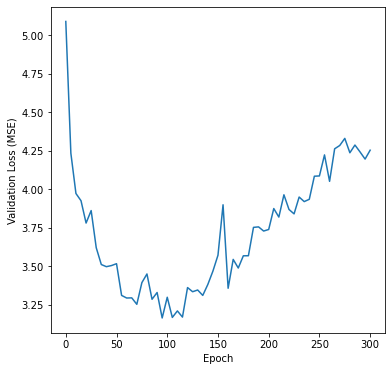

In [68]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(*zip(*L))
plt.xlabel("Epoch")
plt.ylabel("Validation Loss (MSE)")
plt.show()

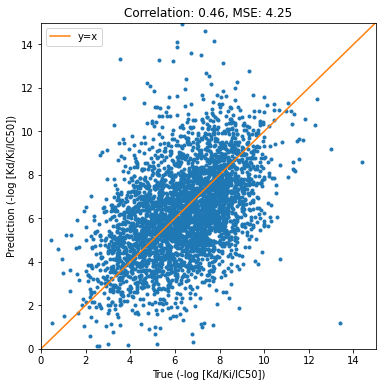

In [69]:
L, Y_pred, Y_true = validation_loss(model, test_loader, mse_loss)

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(Y_true, Y_pred, '.')
ax.plot([0,15], [0,15], label="y=x")
plt.xlim([0, 15])
plt.ylim([0, 15])
corr = np.corrcoef(Y_true, Y_pred)[0,1]
plt.title(f"Correlation: {corr:.2f}, MSE: {L:.2f}")
plt.ylabel("Prediction (-log [Kd/Ki/IC50])")
plt.xlabel("True (-log [Kd/Ki/IC50])")
plt.legend()
plt.show()

In [55]:
torch.cuda.empty_cache()